In [1]:
import numpy as np
import os
import kagglehub
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
ImageFile.LOAD_TRUNCATED_IMAGES = True  # para manejar imágenes corruptas
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, roc_curve, auc,
                           classification_report)
import seaborn as sns
import json
import pandas as pd
import torch
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import urllib.parse

In [2]:
# clase auxiliar para aplicar diferentes transformaciones al train set
class TransformSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [3]:
# descargar datos y hacer los dataloaders
def get_data_loaders(batch_size=64, test_ratio=0.2):

    path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")
    print("Path to dataset files:", path)

    data_dir = os.path.join(path, "PetImages")

    # transformaciones que se harán
    train_transform = transforms.Compose([
        transforms.Resize((70, 70)),  # redimensionar un poco más grande
        transforms.RandomCrop((64, 64)),  # recortar al azar
        transforms.RandomHorizontalFlip(p=0.5),  # volteo horizontal
        transforms.RandomRotation(15),  # rotación de 15 grados
        transforms.RandomAffine(  # otros
            degrees=10,
            translate=(0.1, 0.1),
            scale=(0.9, 1.1),
            shear=10
        ),
        transforms.ColorJitter(  # variaciones de color
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
            hue=0.1
        ),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.1, scale=(0.02, 0.1), value='random'),  # borrado aleatorio
    ])

    # transformaciones para test/validación (tensor, dimension, normalizar)
    test_transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    # cargar dataset completo original
    full_dataset = datasets.ImageFolder(root=data_dir, transform=None)
    print("clases encontradas:", full_dataset.classes)
    print("class_to_idx:", full_dataset.class_to_idx)

    # dividir train/test
    test_size = int(len(full_dataset) * test_ratio)
    train_size = len(full_dataset) - test_size
    train_subset, test_subset = random_split(full_dataset, [train_size, test_size])

    # hacer datasets con transformaciones específicas
    train_dataset = TransformSubset(train_subset, transform=train_transform)
    test_dataset = TransformSubset(test_subset, transform=test_transform)

    print(f"total de imágenes: {len(full_dataset)}")
    print(f"imágenes de train: {len(train_dataset)}, imágenes de test: {len(test_dataset)}")

    # al parecer hay que poner num_workers=0 siempre para evitar problemas con el "multiprocessing" ö
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                           shuffle=False, num_workers=0)

    return train_loader, test_loader, full_dataset.classes, train_transform, test_transform

In [4]:
# red neuronal (CNN)

class gatoperroCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   # de 64 a 32

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   # de 32 a 16

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   # de 16 a 8
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# establecer dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("usando el dispositivo:", device)

# nombre del GPU
if device.type == "cuda":
    print("nombre de la GPU:", torch.cuda.get_device_name(0))

usando el dispositivo: cuda
nombre de la GPU: NVIDIA A100-SXM4-80GB


In [5]:
# función de evaluation
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total if total > 0 else 0.0

In [6]:
# función de train
def train_model(model, train_loader, test_loader, epochs=5, lr=1e-3, start_epoch=0):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(start_epoch, start_epoch + epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            # accuracy en train
            preds = torch.argmax(logits, dim=1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct_train / total_train
        epoch_test_acc = evaluate(model, test_loader)

        train_losses.append(epoch_loss)
        train_accs.append(epoch_train_acc)
        test_accs.append(epoch_test_acc)

        print(
            f"epoch [{epoch+1}]  "
            f"loss: {epoch_loss:.4f}  "
            f"train acc: {epoch_train_acc:.4f}  "
            f"test acc: {epoch_test_acc:.4f}"
        )

    return train_losses, train_accs, test_accs

In [9]:
# configuración
batch_size = 64
epochs = 60
learning_rate = 1e-3
save_dir = "baseline_folder"

# Crear directorio para guardar modelos
os.makedirs(save_dir, exist_ok=True)


# Obtener dataloaders
print("\ncargando datos...")
train_loader, test_loader, class_names, train_transform, test_transform = get_data_loaders(batch_size=batch_size)

# Inicializar modelo
print("\ninicializando modelo...")
model = gatoperroCNN().to(device)
print(f"modelo creado! \nnúmero de parámetros: {sum(p.numel() for p in model.parameters()):,}")

# Listas para almacenar métricas
all_train_losses = []
all_train_accs = []
all_test_accs = []

# Entrenar por épocas
for epoch in range(epochs):
  print(f"\nentrenando epoch {epoch + 1}...")

  model.train()
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  running_loss = 0.0
  correct_train = 0
  total_train = 0
  for batch_idx, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    logits = model(images)
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * images.size(0)

    # Calcular accuracy
    preds = torch.argmax(logits, dim=1)
    correct_train += (preds == labels).sum().item()
    total_train += labels.size(0)

    # Mostrar progreso cada 50 batches
    if (batch_idx + 1) % 50 == 0:
      print(f"batch {batch_idx + 1}/{len(train_loader)}, "
            f"loss: {loss.item():.4f}")

  # Calcular métricas de la época
  epoch_loss = running_loss / len(train_loader.dataset)
  epoch_train_acc = correct_train / total_train
  epoch_test_acc = evaluate(model, test_loader)

  # Guardar métricas
  all_train_losses.append(epoch_loss)
  all_train_accs.append(epoch_train_acc)
  all_test_accs.append(epoch_test_acc)

  # Mostrar resultados de la época
  print(f"\nresultados epoch {epoch + 1}:")
  print(f"loss: {epoch_loss:.4f}")
  print(f"train accuracy: {epoch_train_acc:.4f} ({correct_train}/{total_train})")
  print(f"test accuracy: {epoch_test_acc:.4f}")

  # Guardar modelo
  checkpoint_path = os.path.join(save_dir, f"model_epoch_{epoch + 1}.pth")
  torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
            'train_acc': epoch_train_acc,
            'test_acc': epoch_test_acc,
            'train_losses': all_train_losses,
            'train_accs': all_train_accs,
            'test_accs': all_test_accs,
            'class_names': class_names
    }, checkpoint_path)
  print(f"modelo guardado en: {checkpoint_path}")


print("entrenamiento: COMPLETADO!")

print(f"\nresumen de entrenamiento ({epochs} épocas):")
print(f"mejor accuracy en test: {max(all_test_accs):.4f} (época {all_test_accs.index(max(all_test_accs)) + 1})")
print(f"última loss: {all_train_losses[-1]:.4f}")
print(f"última accuracy en train: {all_train_accs[-1]:.4f}")
print(f"última accuracy en test: {all_test_accs[-1]:.4f}")

final_model_path = os.path.join(save_dir, "model_final.pth")
torch.save({
        'epoch': epochs,
        'model_state_dict': model.state_dict(),
        'train_losses': all_train_losses,
        'train_accs': all_train_accs,
        'test_accs': all_test_accs,
        'class_names': class_names
    }, final_model_path)
print(f"\nmodelo final guardado en: {final_model_path}")


cargando datos...
Using Colab cache for faster access to the 'dog-and-cat-classification-dataset' dataset.
Path to dataset files: /kaggle/input/dog-and-cat-classification-dataset
clases encontradas: ['Cat', 'Dog']
class_to_idx: {'Cat': 0, 'Dog': 1}
total de imágenes: 24998
imágenes de train: 19999, imágenes de test: 4999

inicializando modelo...
modelo creado! 
número de parámetros: 548,258

entrenando epoch 1...
batch 50/313, loss: 0.6479
batch 100/313, loss: 0.7552
batch 150/313, loss: 0.7328
batch 200/313, loss: 0.6029
batch 250/313, loss: 0.6740
batch 300/313, loss: 0.5889

resultados epoch 1:
loss: 0.6494
train accuracy: 0.6157 (12314/19999)
test accuracy: 0.6889
modelo guardado en: baseline_folder/model_epoch_1.pth

entrenando epoch 2...
batch 50/313, loss: 0.6970
batch 100/313, loss: 0.5260
batch 150/313, loss: 0.6042
batch 200/313, loss: 0.5421
batch 250/313, loss: 0.5443
batch 300/313, loss: 0.4296

resultados epoch 2:
loss: 0.5824
train accuracy: 0.6909 (13818/19999)
test ac

Graficar los resultados:

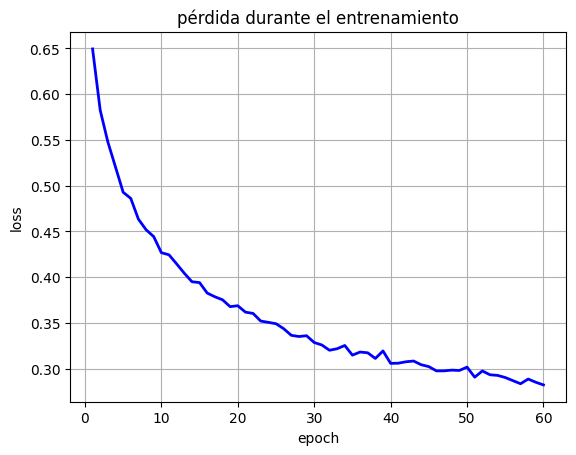

In [10]:
plt.plot(range(1, epochs + 1), all_train_losses, 'b-', linewidth=2)
plt.title('pérdida durante el entrenamiento')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.show()

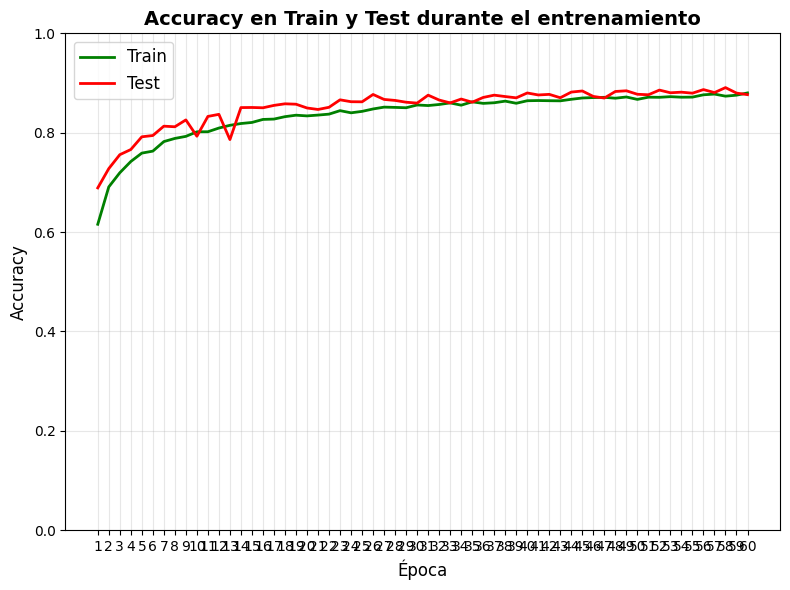

In [11]:
# Gráfica combinada de accuracy en train y test
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), all_train_accs, 'g-', linewidth=2, label='Train')
plt.plot(range(1, epochs + 1), all_test_accs, 'r-', linewidth=2, label='Test')
plt.title('Accuracy en Train y Test durante el entrenamiento', fontsize=14, fontweight='bold')
plt.xlabel('Época', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim([0, 1])
plt.legend(fontsize=12)
plt.xticks(range(1, epochs + 1))
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "training_accuracy_comparison.png"))
plt.show()

In [24]:
# cargar y probar el mejor modelo
best_epoch = all_test_accs.index(max(all_test_accs)) + 1
best_model_path = os.path.join(save_dir, f"model_epoch_{best_epoch}.pth")

print(f"\ncargando el mejor modelo (epoch {best_epoch})...")
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluar el mejor modelo
final_test_acc = evaluate(model, test_loader)
print(f"accuracy del mejor modelo en test: {final_test_acc:.4f}")


cargando el mejor modelo (epoch 58)...
accuracy del mejor modelo en test: 0.9060


In [18]:
def calculate_metrics(model, test_loader, device, class_names=['Cat', 'Dog']):
    # función para calcular todas las métricas de una
    model.eval()

    # almacenar predicciones y etiquetas reales
    all_predictions = []
    all_labels = []
    all_probabilities = []  # probabilidades para la clase positiva (perrito)

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            probabilities = torch.softmax(logits, dim=1)

            predictions = torch.argmax(logits, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities[:, 1].cpu().numpy())  # Probabilidad de ser perro

    # pasar a numpy
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_probabilities = np.array(all_probabilities)


    # métricas básiconas
    # accuracy
    accuracy = accuracy_score(all_labels, all_predictions)

    # gato = 0 & perro = 1

    precision_dog = precision_score(all_labels, all_predictions, pos_label=1)

    # recall para perro
    recall_dog = recall_score(all_labels, all_predictions, pos_label=1)

    # F1-Score para perro
    f1_dog = f1_score(all_labels, all_predictions, pos_label=1)

    # Matriz de confusión
    cm = confusion_matrix(all_labels, all_predictions)

    # calcular specificity para gato (clase 0)
    # specificity = TN / (TN + FP)
    tn, fp, fn, tp = cm.ravel()
    specificity_cat = tn / (tn + fp) if (tn + fp) > 0 else 0


    # roc y área bajo la curva
    fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities, pos_label=1)
    roc_auc = auc(fpr, tpr)

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]


    # reporte automático
    print("evaluación automática del modelo")

    print(f"\nconfiguración de clases:")
    print(f"Clase 0: {class_names[0]}")
    print(f"Clase 1: {class_names[1]}")

    print(f"\nmétricas básicas:")
    print(f"accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

    # metas
    accuracy_meta = 0.95
    precision_meta = 0.93
    recall_meta = 0.93
    f1_meta = 0.93
    specificity_meta = 0.93
    auc_meta = 0.97

    print(f"\nmetas establecidas")
    print(f"exactitud mayor o igual a {accuracy_meta*100:.0f}%")
    print(f"precisión (dog) mayor o igual a {precision_meta*100:.0f}%")
    print(f"sensibility (dog) mayor o igual a {recall_meta*100:.0f}%")
    print(f"F1-Score (dog) mayor o igual a {f1_meta*100:.0f}%")
    print(f"specificity (cat) mayor o igual a {specificity_meta*100:.0f}%")
    print(f"AUC-ROC: > {auc_meta}")

    print(f"\n\nresultados obtenidos:")

    # Función para formatear resultados con iconos de cumplimiento
    def formato_metrica(valor, meta, nombre):
        cumplimiento = "✅" if valor >= meta else "❌"
        porcentaje = f"{valor*100:.2f}%"
        return f"   {cumplimiento} {nombre}: {porcentaje} (Meta: ≥{meta*100:.0f}%)"

    print(formato_metrica(accuracy, accuracy_meta, "exactitud"))
    print(formato_metrica(precision_dog, precision_meta, "precisión (dog)"))
    print(formato_metrica(recall_dog, recall_meta, "sensibility (dog)"))
    print(formato_metrica(f1_dog, f1_meta, "F1 (dog)"))
    print(formato_metrica(specificity_cat, specificity_meta, "specificity (cat)"))
    print(formato_metrica(roc_auc, auc_meta, "AUC-ROC"))


    print(f"\n\n reporte de clasificación:")
    print(classification_report(all_labels, all_predictions,
                                target_names=class_names, digits=4))

    # visualizaciones

    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('evaluación del modelo de clasificación',
                 fontsize=16, fontweight='bold')

    # 1 - matriz de confusión
    ax1 = axes[0, 0]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax1)
    ax1.set_title('matriz de confusión', fontweight='bold')
    ax1.set_xlabel('predicción')
    ax1.set_ylabel('real')
    ax1.text(0.5, -0.15, f'TP={tp}, TN={tn}, FP={fp}, FN={fn}',
             ha='center', va='center', transform=ax1.transAxes, fontsize=10)

    # 2 - métricas por clase
    ax2 = axes[0, 1]
    metrics_per_class = {
        'precisión': [precision_score(all_labels, all_predictions, pos_label=0),
                      precision_dog],
        'sensibilidad': [recall_score(all_labels, all_predictions, pos_label=0),
                         recall_dog],
        'F1': [f1_score(all_labels, all_predictions, pos_label=0), f1_dog]
    }

    x = np.arange(len(class_names))
    width = 0.25
    multiplier = 0

    for attribute, measurement in metrics_per_class.items():
        offset = width * multiplier
        rects = ax2.bar(x + offset, measurement, width, label=attribute)
        ax2.bar_label(rects, padding=3, fmt='%.3f')
        multiplier += 1

    ax2.set_title('métricas por clase', fontweight='bold')
    ax2.set_xlabel('clase')
    ax2.set_ylabel('valor')
    ax2.set_xticks(x + width, class_names)
    ax2.legend(loc='upper right', ncol=3)
    ax2.set_ylim(0, 1.1)

    # 3 - curva roc
    ax3 = axes[1,0]
    ax3.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'curva ROC (AUC = {roc_auc:.4f})')
    ax3.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')

    ax3.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=10,
             label=f'óptimo: {optimal_threshold:.3f}')

    ax3.set_xlim([0.0, 1.0])
    ax3.set_ylim([0.0, 1.05])
    ax3.set_xlabel('tasa de falsos positivos')
    ax3.set_ylabel('tasa de verdaderos positivos')
    ax3.set_title('curva ROC', fontweight='bold')
    ax3.legend(loc="lower right")
    ax3.grid(True, alpha=0.3)

    # 4 - distribución de probabilidades
    ax4 = axes[1, 1]

    # probabilidades por clase real
    prob_dog_real_dog = all_probabilities[all_labels == 1]
    prob_dog_real_cat = all_probabilities[all_labels == 0]

    ax4.hist(prob_dog_real_cat, bins=30, alpha=0.7, label='Gatos Reales',
             color='blue', density=True)
    ax4.hist(prob_dog_real_dog, bins=30, alpha=0.7, label='Perros Reales',
             color='red', density=True)

    ax4.axvline(x=optimal_threshold, color='green', linestyle='--',
                label=f'óptimo: {optimal_threshold:.3f}')

    ax4.set_xlabel('probabilidad de ser perrito')
    ax4.set_ylabel('densidad')
    ax4.set_title('distribución de probabilidades', fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\nresumen final")

    metricas = [accuracy, precision_dog, recall_dog, f1_dog, specificity_cat, roc_auc]
    metas = [accuracy_meta, precision_meta, recall_meta, f1_meta, specificity_meta, auc_meta]

    cumplimiento = sum(1 for m, meta in zip(metricas, metas) if m >= meta)
    porcentaje_cumplimiento = (cumplimiento / len(metas)) * 100

    total_metas = len(metas)
    metas_cumplidas = cumplimiento

    print(f"\ncalificación: {porcentaje_cumplimiento:.1f}%")
    print(f"   ({metas_cumplidas} de {total_metas} metas cumplidas)")

    if porcentaje_cumplimiento == 100:
        print("\nse cumplieron todas las metas!! :)")
    elif porcentaje_cumplimiento >= 80:
        print("\nse cumple la mayoría de las metas.")
    elif porcentaje_cumplimiento >= 60:
        print("\nalgunas metas no se cumplieron")
    else:
        print("\nno se cumplieron la mayoría de las metas")

    metrics_dict = {
        'accuracy': accuracy,
        'precision_dog': precision_dog,
        'recall_dog': recall_dog,
        'f1_dog': f1_dog,
        'specificity_cat': specificity_cat,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'roc_curve': (fpr, tpr, thresholds),
        'optimal_threshold': optimal_threshold,
        'all_predictions': all_predictions,
        'all_labels': all_labels,
        'all_probabilities': all_probabilities
    }

    return metrics_dict

In [14]:
def evaluate_specific_image(model, image_path, transform, class_names, device):
    from PIL import Image

    model.eval()

    img = Image.open(image_path).convert("RGB")

    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(img_tensor)
        probabilities = torch.softmax(logits, dim=1)[0].cpu().numpy()
        prediction = torch.argmax(logits, dim=1).item()

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # imagen original
    axes[0].imshow(img)
    axes[0].axis('off')
    axes[0].set_title('Imagen Original')

    # probabilidades
    colors = ['blue' if i == prediction else 'gray' for i in range(len(class_names))]
    bars = axes[1].bar(class_names, probabilities, color=colors)
    axes[1].set_ylim([0, 1])
    axes[1].set_ylabel('Probabilidad')
    axes[1].set_title('Probabilidades de Clasificación')

    # Añadir valores en las barras
    for bar, prob in zip(bars, probabilities):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{prob:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    print(f"\nresultado de clasificación:")
    print(f"predicción: {class_names[prediction]} (confianza: {probabilities[prediction]:.4f})")
    print(f"\ndistribución de probabilidades:")
    for cls, prob in zip(class_names, probabilities):
        print(f"   {cls}: {prob:.4f}")

    return prediction, probabilities

In [31]:
def evaluate_image_from_url(model, image_url, transform, class_names, device):
    try:
        # Parsear la URL para obtener la URL real de la imagen
        parsed_url = urllib.parse.urlparse(image_url)

        # Si es una URL de Google Images, extraer la URL real
        if 'google.com' in parsed_url.netloc and 'url=' in parsed_url.query:
            query_params = urllib.parse.parse_qs(parsed_url.query)
            if 'url' in query_params:
                image_url = query_params['url'][0]

        # Descargar la imagen
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        response = requests.get(image_url, headers=headers, timeout=10)
        response.raise_for_status()

        # Abrir la imagen
        img = Image.open(BytesIO(response.content)).convert('RGB')

    except Exception as e:
        print(f"error al descargar la imagen: {e} :(")
        return None, None

    model.eval()

    # Preparar la imagen para el modelo
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Realizar predicción
    with torch.no_grad():
        logits = model(img_tensor)
        probabilities = torch.softmax(logits, dim=1)[0].cpu().numpy()
        prediction = torch.argmax(logits, dim=1).item()

    # Crear visualización
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Mostrar imagen original
    axes[0].imshow(img)
    axes[0].axis('off')
    axes[0].set_title('imagen evaluada')

    # Mostrar probabilidades
    colors = ['green' if i == prediction else 'gray' for i in range(len(class_names))]
    bars = axes[1].barh(class_names, probabilities, color=colors)
    axes[1].set_xlim([0, 1])
    axes[1].set_xlabel('probabilidad')
    axes[1].set_title('probabilidades de Clasificación')
    axes[1].grid(axis='x', alpha=0.3)

    # Añadir valores de probabilidad
    for bar, prob in zip(bars, probabilities):
        width = bar.get_width()
        axes[1].text(width + 0.01, bar.get_y() + bar.get_height()/2,
                    f'{prob:.4f}', ha='left', va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Mostrar resultados en consola

    print("\nresultados:")
    print("="*60)
    print(f"se predice que esta imagen corresponde a un: {class_names[prediction]}")
    print(f"con una confianza de: {probabilities[prediction]:.4f}")
    print("distribución completa de probabilidades:")
    for i, (cls, prob) in enumerate(zip(class_names, probabilities)):
        print(f"{i+1:2}. {cls:20}: {prob:.4f} {'★' if i == prediction else ''}")
    print("="*60)

    return prediction, probabilities

Evaluación del modelo con las métricas establecidas en el reporte

Cargando modelo entrenado...
modelo cargado desde: baseline_folder/model_final.pth
epochs entrenadas: 60
mejor accuracy en test: 0.8908

cargando datos de prueba...
Using Colab cache for faster access to the 'dog-and-cat-classification-dataset' dataset.
Path to dataset files: /kaggle/input/dog-and-cat-classification-dataset
clases encontradas: ['Cat', 'Dog']
class_to_idx: {'Cat': 0, 'Dog': 1}
total de imágenes: 24998
imágenes de train: 19999, imágenes de test: 4999
evaluación automática del modelo

configuración de clases:
Clase 0: Cat
Clase 1: Dog

métricas básicas:
accuracy: 0.8930 (89.30%)

metas establecidas
exactitud mayor o igual a 95%
precisión (dog) mayor o igual a 93%
sensibility (dog) mayor o igual a 93%
F1-Score (dog) mayor o igual a 93%
specificity (cat) mayor o igual a 93%
AUC-ROC: > 0.97


resultados obtenidos:
   ❌ exactitud: 89.30% (Meta: ≥95%)
   ❌ precisión (dog): 85.57% (Meta: ≥93%)
   ✅ sensibility (dog): 94.96% (Meta: ≥93%)
   ❌ F1 (dog): 90.02% (Meta: ≥93%)
   ❌ s

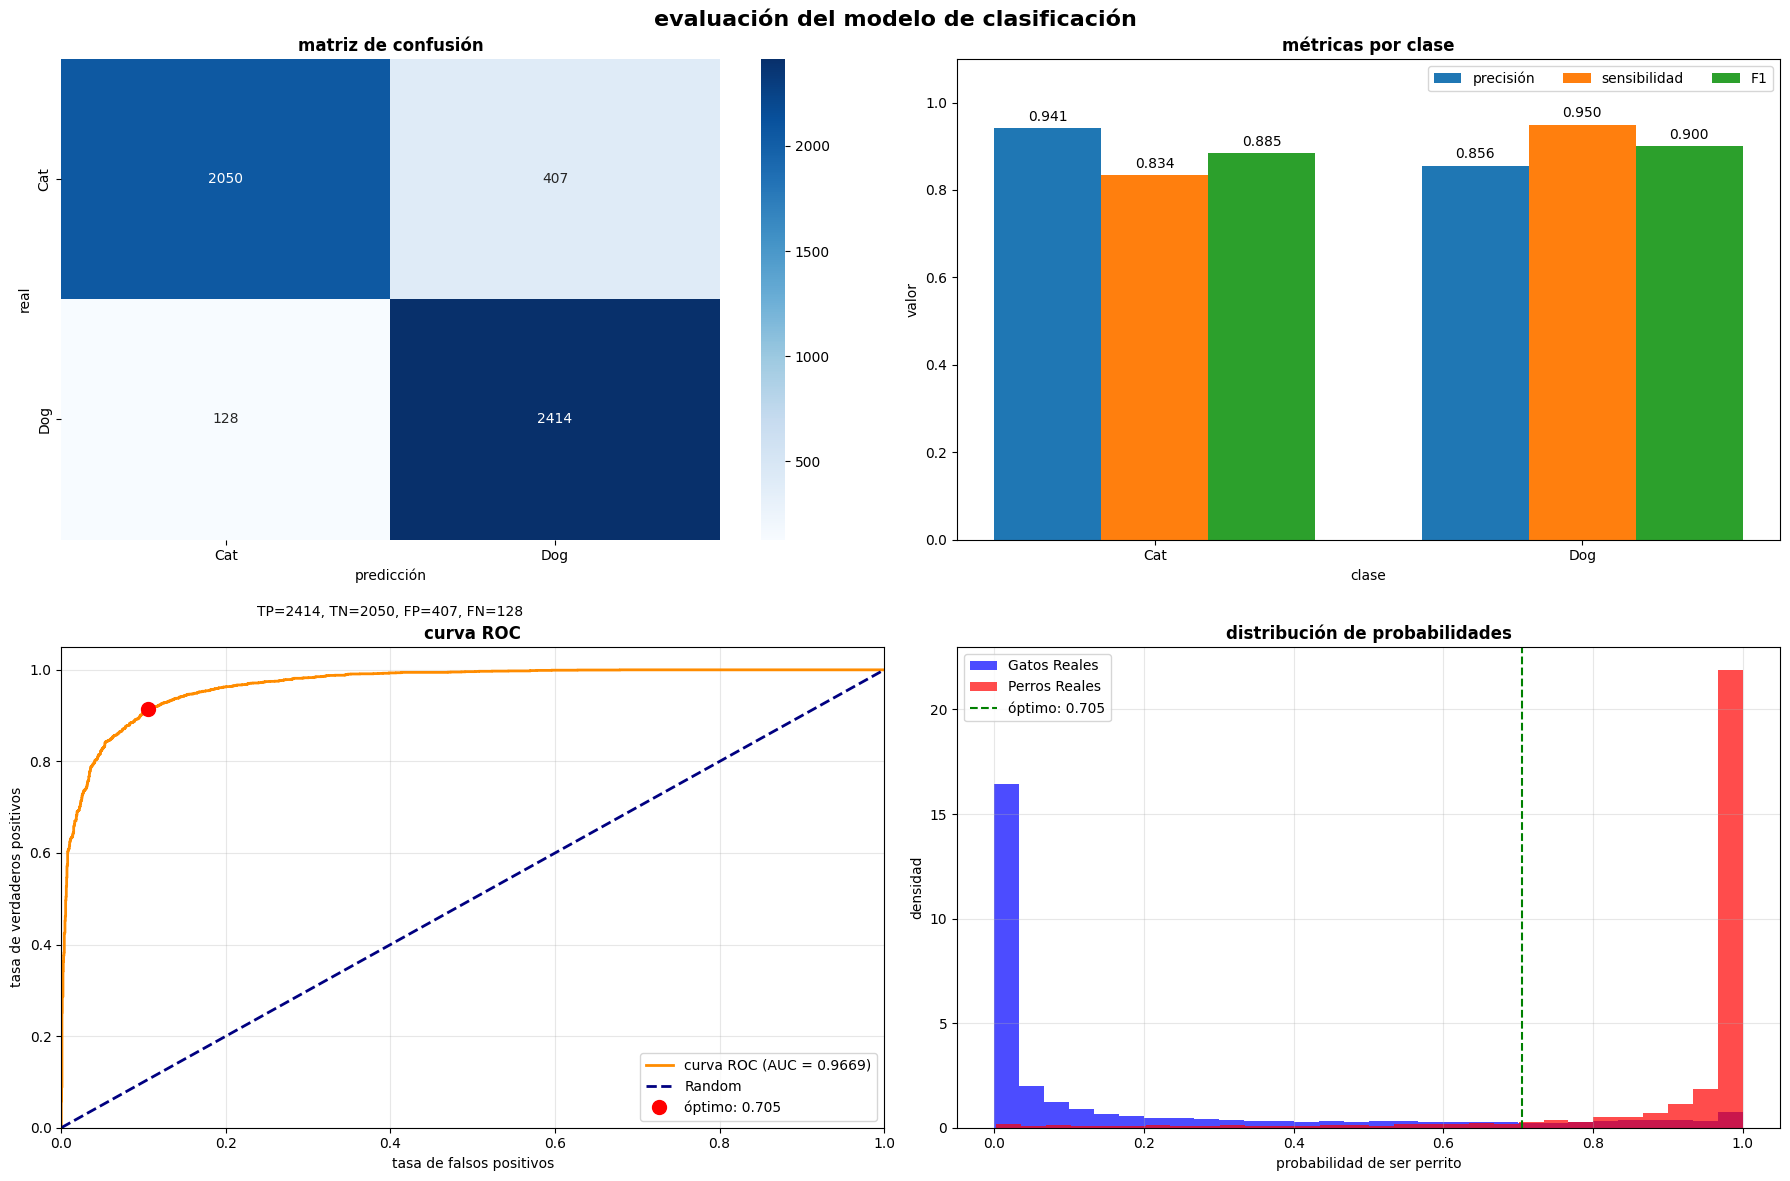


resumen final

calificación: 16.7%
   (1 de 6 metas cumplidas)

no se cumplieron la mayoría de las metas


In [19]:
print("Cargando modelo entrenado...")
checkpoint_path = "baseline_folder/model_final.pth"

checkpoint = torch.load(checkpoint_path, map_location=device)
model = gatoperroCNN().to(device)
model.load_state_dict(checkpoint['model_state_dict'])

print(f"modelo cargado desde: {checkpoint_path}")
print(f"epochs entrenadas: {checkpoint.get('epoch', 'N/A')}")
print(f"mejor accuracy en test: {max(checkpoint.get('test_accs', [0])):.4f}")

# cargar los dataloaders para laevaluación
print("\ncargando datos de prueba...")
_, test_loader, class_names, _, test_transform = get_data_loaders(batch_size=64)

metrics = calculate_metrics(model, test_loader, device, class_names)

# crear dataframe con métricas
metrics_df = pd.DataFrame({
        'métrica': ['accuracy', 'precision (dog)', 'recall (dog)',
                   'F1-Score (dog)', 'specificity (cat)', 'AUC-ROC'],
        'valor': [metrics['accuracy'], metrics['precision_dog'],
                 metrics['recall_dog'], metrics['f1_dog'],
                 metrics['specificity_cat'], metrics['roc_auc']],
        'meta': [0.95, 0.93, 0.93, 0.93, 0.93, 0.97],
        'cumple': ['✅' if metrics['accuracy'] >= 0.95 else '❌',
                  '✅' if metrics['precision_dog'] >= 0.93 else '❌',
                  '✅' if metrics['recall_dog'] >= 0.93 else '❌',
                  '✅' if metrics['f1_dog'] >= 0.93 else '❌',
                  '✅' if metrics['specificity_cat'] >= 0.93 else '❌',
                  '✅' if metrics['roc_auc'] >= 0.97 else '❌']
    })

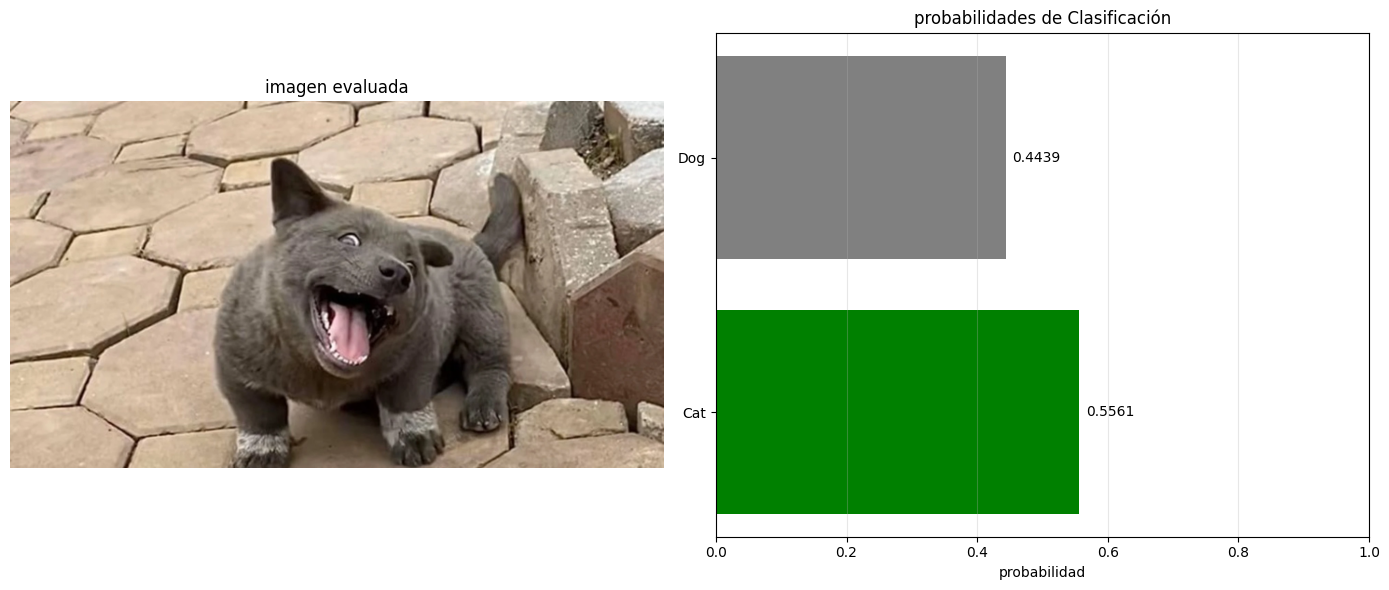


resultados:
se predice que esta imagen corresponde a un: Cat
con una confianza de: 0.5561
distribución completa de probabilidades:
 1. Cat                 : 0.5561 ★
 2. Dog                 : 0.4439 


In [32]:
image_url = "https://image.europafm.com/clipping/cmsimages02/2020/03/04/DA7C101A-9CCC-4495-8AFD-EBEE80F76CC8/98.jpg?crop=669,376,x0,y43&width=1900&height=1069&optimize=low&format=webply"
prediction, probabilities = evaluate_image_from_url(
        model=model,
        image_url=image_url,
        transform= test_transform,
        class_names=class_names,
        device=device)

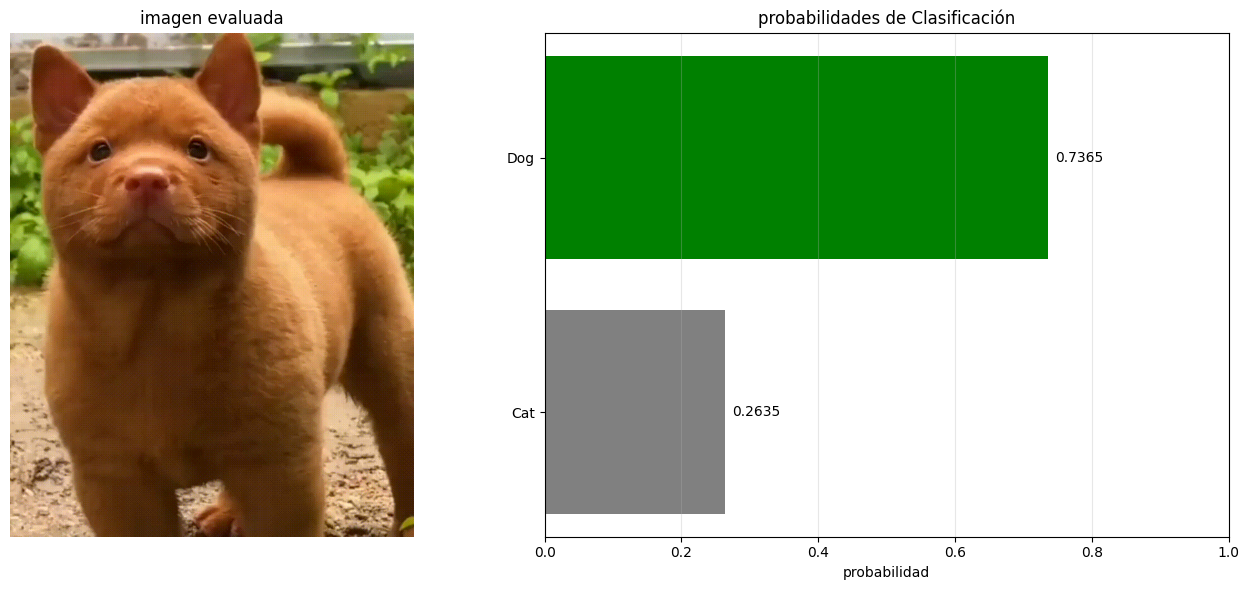


resultados:
se predice que esta imagen corresponde a un: Dog
con una confianza de: 0.7365
distribución completa de probabilidades:
 1. Cat                 : 0.2635 
 2. Dog                 : 0.7365 ★


In [33]:
image_url = "https://external-preview.redd.it/ZcEHQjokSliQDuwg2m7hpDjwy29WEypJIfzefqka8qY.gif?format=png8&s=b66f32e891806d0fc4cd3ee492ac8b4f8e6f47a5"

prediction, probabilities = evaluate_image_from_url(
        model=model,
        image_url=image_url,
        transform= test_transform,
        class_names=class_names,
        device=device)

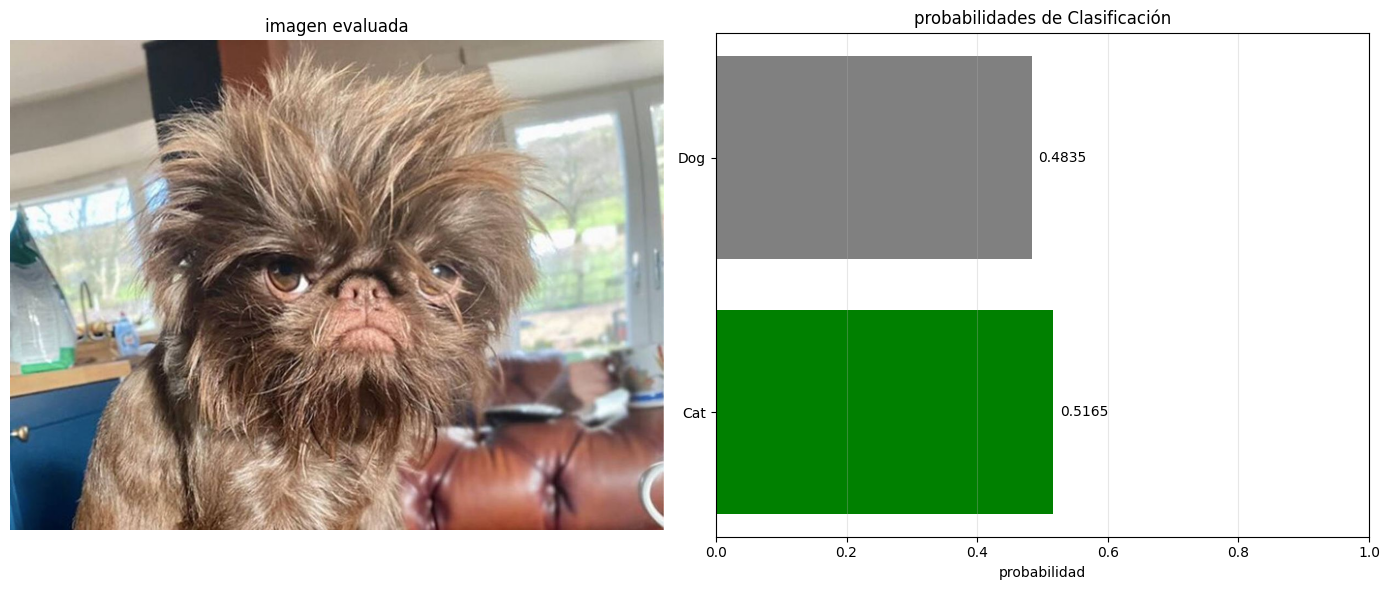


resultados:
se predice que esta imagen corresponde a un: Cat
con una confianza de: 0.5165
distribución completa de probabilidades:
 1. Cat                 : 0.5165 ★
 2. Dog                 : 0.4835 


In [34]:
image_url = "https://images.ecestaticos.com/0Hpy1_mGylEw9puc5KzHG227wok=/0x0:1000x750/1200x900/filters:fill(white):format(jpg)/f.elconfidencial.com%2Foriginal%2F8ec%2Ffde%2Fa8b%2F8ecfdea8b0e364213f02fefe2c084cb5.jpg"

prediction, probabilities = evaluate_image_from_url(
        model=model,
        image_url=image_url,
        transform= test_transform,
        class_names=class_names,
        device=device)

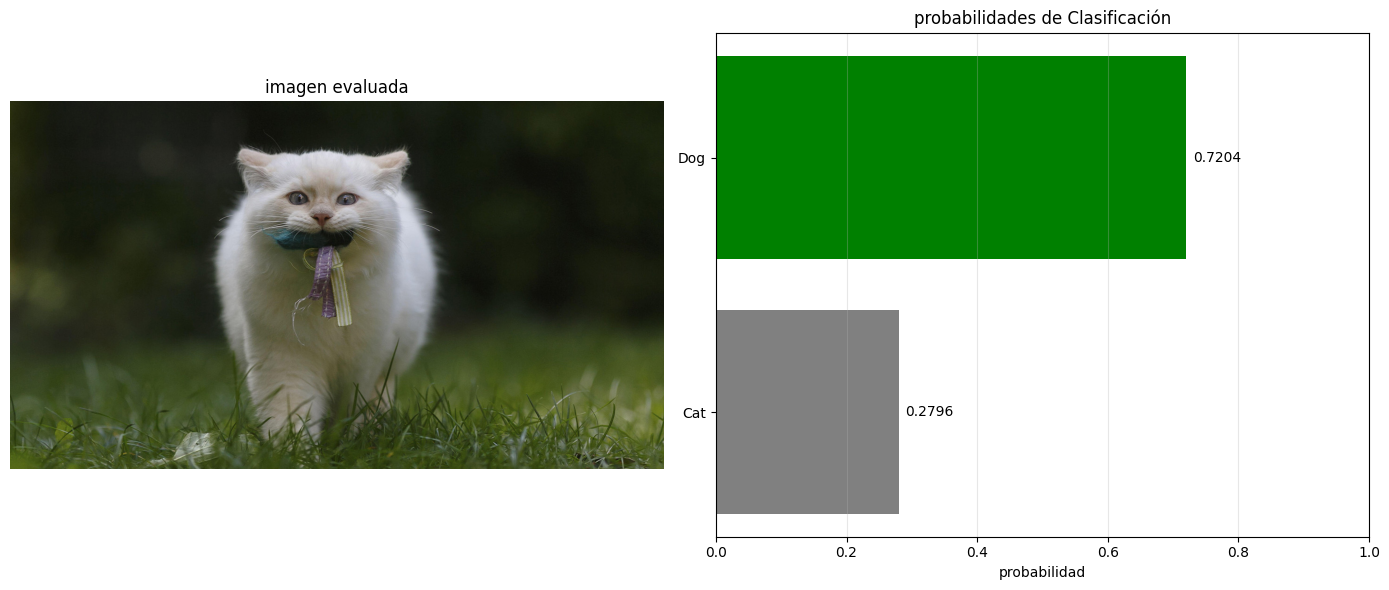


resultados:
se predice que esta imagen corresponde a un: Dog
con una confianza de: 0.7204
distribución completa de probabilidades:
 1. Cat                 : 0.2796 
 2. Dog                 : 0.7204 ★


In [35]:
image_url = "https://cdn.mos.cms.futurecdn.net/CZPj6BF2ZaNchndwUjqdtQ.jpg"
prediction, probabilities = evaluate_image_from_url(
        model=model,
        image_url=image_url,
        transform= test_transform,
        class_names=class_names,
        device=device)

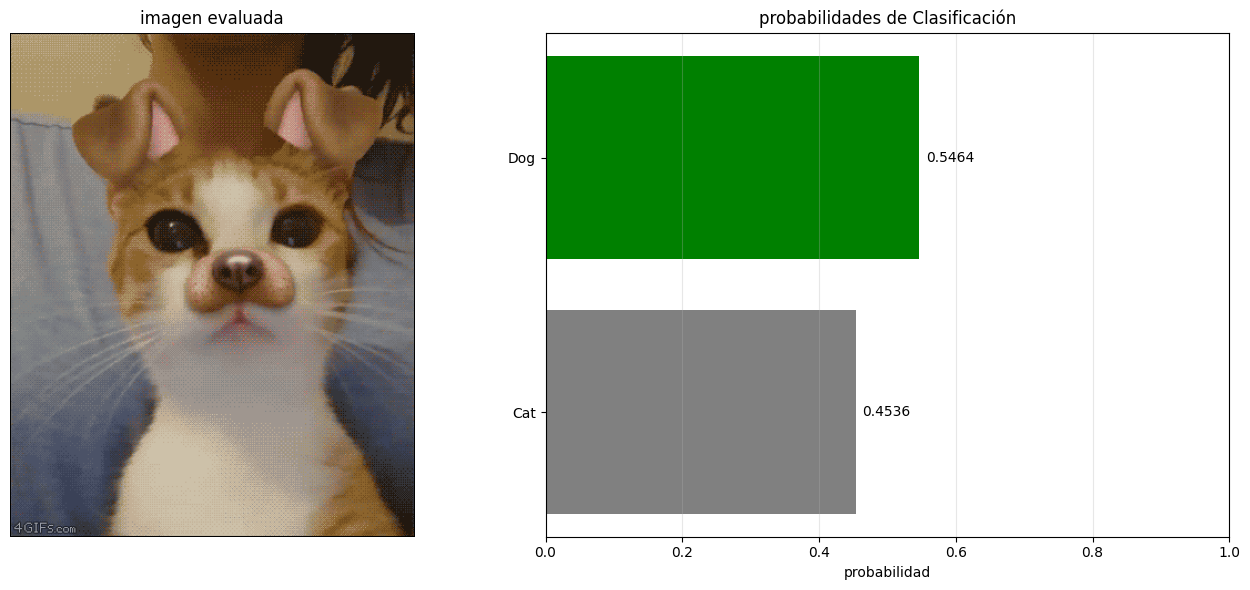


resultados:
se predice que esta imagen corresponde a un: Dog
con una confianza de: 0.5464
distribución completa de probabilidades:
 1. Cat                 : 0.4536 
 2. Dog                 : 0.5464 ★


In [36]:
image_url = "https://i.pinimg.com/originals/18/b3/14/18b3141b565855b626069f16e064f51b.gif"
prediction, probabilities = evaluate_image_from_url(
        model=model,
        image_url=image_url,
        transform= test_transform,
        class_names=class_names,
        device=device)

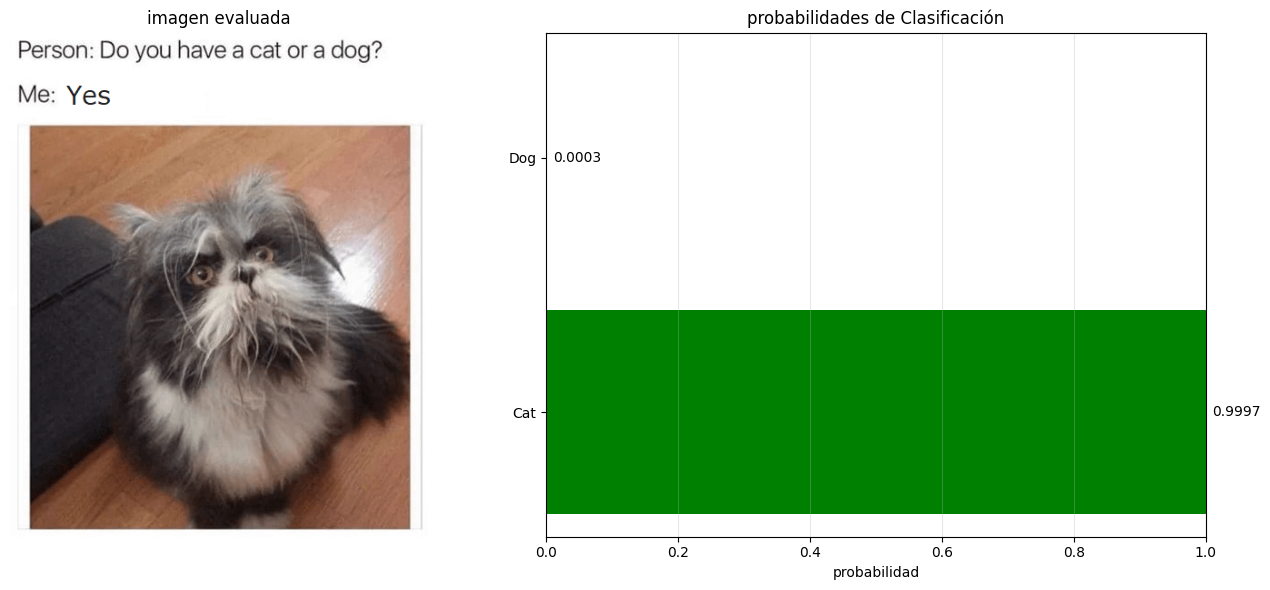


resultados:
se predice que esta imagen corresponde a un: Cat
con una confianza de: 0.9997
distribución completa de probabilidades:
 1. Cat                 : 0.9997 ★
 2. Dog                 : 0.0003 


In [37]:
image_url = "https://preview.redd.it/3qel507lp1g31.png?auto=webp&s=7fc8f3b891d82389fe5183fa3a8c959efc685cea"
prediction, probabilities = evaluate_image_from_url(
        model=model,
        image_url=image_url,
        transform= test_transform,
        class_names=class_names,
        device=device)

In [20]:
# guardar todo en csv's
metrics_df.to_csv('metricas_evaluacion.csv', index=False)
print("métricas guardadas en 'metricas_evaluacion.csv'")

np.savetxt('matriz_de_confusion.csv', metrics['confusion_matrix'], delimiter=',', fmt='%d')

roc_data = np.column_stack(metrics['roc_curve'])
np.savetxt('curva_roc.csv', roc_data, delimiter=',', header='FPR,TPR,Threshold', comments='')

print("\nevaluación completada!")

métricas guardadas en 'metricas_evaluacion.csv'

evaluación completada!


Guardar la carpeta

In [21]:
!pwd
!ls -la

nombre_carpeta = "baseline_folder"
!zip -r {nombre_carpeta}.zip {nombre_carpeta}/
from google.colab import files
files.download(f'{nombre_carpeta}.zip')

/content
total 92
drwxr-xr-x 1 root root  4096 Dec  4 22:18 .
drwxr-xr-x 1 root root  4096 Dec  4 20:26 ..
drwxr-xr-x 2 root root  4096 Dec  4 22:12 baseline_folder
drwxr-xr-x 4 root root  4096 Nov 20 14:30 .config
-rw-r--r-- 1 root root 63897 Dec  4 22:18 curva_roc.csv
-rw-r--r-- 1 root root    18 Dec  4 22:18 matriz_de_confusion.csv
-rw-r--r-- 1 root root   274 Dec  4 22:18 metricas_evaluacion.csv
drwxr-xr-x 1 root root  4096 Nov 20 14:30 sample_data
  adding: baseline_folder/ (stored 0%)
  adding: baseline_folder/model_epoch_10.pth (deflated 55%)
  adding: baseline_folder/model_epoch_33.pth (deflated 53%)
  adding: baseline_folder/model_epoch_16.pth (deflated 54%)
  adding: baseline_folder/model_epoch_39.pth (deflated 52%)
  adding: baseline_folder/model_epoch_22.pth (deflated 53%)
  adding: baseline_folder/model_epoch_35.pth (deflated 52%)
  adding: baseline_folder/model_epoch_48.pth (deflated 51%)
  adding: baseline_folder/model_epoch_6.pth (deflated 53%)
  adding: baseline_folder

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
!zip -r baseline.zip /content/baseline_folder
from google.colab import files
files.download('baseline.zip')

  adding: content/baseline_folder/ (stored 0%)
  adding: content/baseline_folder/model_epoch_10.pth (deflated 55%)
  adding: content/baseline_folder/model_epoch_33.pth (deflated 53%)
  adding: content/baseline_folder/model_epoch_16.pth (deflated 54%)
  adding: content/baseline_folder/model_epoch_39.pth (deflated 52%)
  adding: content/baseline_folder/model_epoch_22.pth (deflated 53%)
  adding: content/baseline_folder/model_epoch_35.pth (deflated 52%)
  adding: content/baseline_folder/model_epoch_48.pth (deflated 51%)
  adding: content/baseline_folder/model_epoch_6.pth (deflated 53%)
  adding: content/baseline_folder/model_epoch_8.pth (deflated 54%)
  adding: content/baseline_folder/model_epoch_38.pth (deflated 52%)
  adding: content/baseline_folder/model_epoch_13.pth (deflated 54%)
  adding: content/baseline_folder/model_epoch_47.pth (deflated 51%)
  adding: content/baseline_folder/model_epoch_34.pth (deflated 53%)
  adding: content/baseline_folder/model_epoch_15.pth (deflated 54%)
  a

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/baseline_folder /content/drive/MyDrive/

Mounted at /content/drive
